Create compression version of GPT-2 nad BERT model and save the memory =)

## stsb example

The Semantic Textual Similarity Benchmark (Cer et al., 2017) is a collection of sentence pairs drawn from news headlines, video and image captions, and natural language inference data. Each pair is human-annotated with a similarity score from 0 to 5.

In [1]:
#!pip install Partial State

In [1]:
import transformers
print (transformers.__version__)

4.30.2


In [2]:
#!pip install datasets evaluate

In [3]:
#!pip3 install --upgrade pip
#!pip3 install --upgrade transformers

In [4]:
from datasets import load_dataset
import pandas as pd

dataset_stsb = load_dataset('glue', 'stsb')
dataset_stsb.num_rows

Found cached dataset glue (/root/.cache/huggingface/datasets/glue/stsb/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

{'train': 5749, 'validation': 1500, 'test': 1379}

In [5]:
pd.DataFrame(dataset_stsb['train']).head(13)

,sentence1,sentence2,label,idx
0,A plane is taking off.,An air plane is taking off.,5.000,0
1,A man is playing a large flute.,A man is playing a flute.,3.800,1
2,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...,3.800,2
3,Three men are playing chess.,Two men are playing chess.,2.600,3
4,A man is playing the cello.,A man seated is playing the cello.,4.250,4
5,Some men are fighting.,Two men are fighting.,4.250,5
6,A man is smoking.,A man is skating.,0.500,6
7,The man is playing the piano.,The man is playing the guitar.,1.600,7
8,A man is playing on a guitar and singing.,A woman is playing an acoustic guitar and sing...,2.200,8
9,A person is throwing a cat on to the ceiling.,A person throws a cat on the ceiling.,5.000,9


In [6]:
task_num_labels = 1

from transformers import AutoConfig, BertConfig, AutoModelForSequenceClassification, AutoTokenizer

path_name = r"bert-base-uncased"

config = AutoConfig.from_pretrained(
    path_name,
    num_labels=task_num_labels,
)

model = AutoModelForSequenceClassification.from_pretrained(
    path_name,
    config=config,
)

tokenizer = AutoTokenizer.from_pretrained(path_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [7]:
def convert_to_stsb_features(example_batch):
    inputs = list(zip(example_batch['sentence1'], example_batch['sentence2']))
    features = tokenizer.batch_encode_plus(
        inputs, max_length=128, truncation=True, padding="max_length")
    features["labels"] = example_batch["label"]
    return features

In [8]:
tokenized_dataset = dataset_stsb.map(
            convert_to_stsb_features,
            batched=True,
            load_from_cache_file=False,
            )

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [9]:
from torch.utils.data import DataLoader, RandomSampler

eval_dataloader = DataLoader(tokenized_dataset['validation'], batch_size=10)


In [10]:
type(tokenized_dataset)

datasets.dataset_dict.DatasetDict

Due to OOM errors with TTM, we need a optimized einsum version

In [11]:
#!pip install gdown
#!gdown https://drive.google.com/uc?id=1jfJWEtEo9CIbH-I56EFZ8_EyK_PcZtNn

In [12]:
def freeze_bert(model):
    for module in model.bert.embeddings.parameters():
        module.requires_grad = False
            
    for layer in range(len(model.bert.encoder.layer)):
        for module in model.bert.encoder.layer[layer].attention.self.parameters():
            module.requires_grad = False
                    
        for module in model.bert.encoder.layer[layer].attention.output.parameters():
            module.requires_grad = False

In [13]:

#device = 'cpu'

In [14]:
from transformers import Trainer
import evaluate as ev
import numpy as np

from transformers import TrainingArguments, Trainer, EvalPrediction

2023-07-18 11:07:51.235039: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [15]:
metric = ev.load("glue", 'stsb')

In [16]:
model.bert.encoder.layer[7].intermediate.dense

Linear(in_features=768, out_features=3072, bias=True)

In [17]:
import numpy as np
import matplotlib.pyplot as plt

In [18]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 5749
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1500
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1379
    })
})

In [19]:
def get_top_k_element(matrix, number):
    arr = torch.reshape(matrix, (-1,))
    a = torch.topk(arr, number)
    return a.values[number-1]

In [20]:
def func_collecting_tensors(step, tensor1, tensor2=None):
    if step == 0:
        return tensor1.unsqueeze(0)
    else:
        return torch.concatenate((tensor1, tensor2),0)
    
def Tucker_Decomposition_anna(tensor):
    n1, n2, n3 = tensor.shape
    u1, _, _ = torch.svd(torch.reshape(tensor, (n1, -1)))
    u2, _, _ = torch.svd(torch.reshape(torch.permute(tensor, [1, 2, 0]), (n2, -1)))
    u3, _, _ = torch.svd(torch.reshape(torch.permute(tensor, [2, 0, 1]), (n3, -1)))
    return u1, u2
    
def Tucker_Decomposition(tensor):
    n1, n2, n3 = tensor.shape
    u1, s1, v1 = np.linalg.svd(np.reshape(tensor, (n1, -1)), full_matrices=False)
    u2, s1, v1 = np.linalg.svd(np.reshape(np.transpose(tensor,[1,2,0]), (n2, -1)), full_matrices=False)
    u3, s1, v1 = np.linalg.svd(np.reshape(np.transpose(tensor,[2,0,1]), (n3, -1)), full_matrices=False)
    return u1, u2

def get_tucker_tensor(list_layer):
    '''
    делает словарь где ключом будет слой, а значением будет тензор
    '''
    dict_tensor = np.moveaxis(np.stack(list_layer, axis = 0), 0, 2)
    return dict_tensor

def get_tucker_tensors(dict_layers):
    '''
    делает словарь где ключом будет слой, а значением будет тензор
    '''
    dict_tensor = dict(zip(range(12), [None]*12))
    for key in dict_layers.keys():
        dict_tensor[key] = np.moveaxis(np.stack(dict_layers[key][:28], axis = 0), 0, 2)
    return dict_tensor

In [23]:
import torch

import matplotlib.pyplot as plt

class CustomTrainerBertregular(Trainer):
    def make_grad_bank(self, model):
        self.grad_bank_out_epoch = []
        self.grad_bank_int_epoch = []
        self.grad_bank_out = {i:[] for i in range(model.config.num_hidden_layers)}
        self.grad_bank_int = {i:[] for i in range(model.config.num_hidden_layers)}

        self.sparse_grad_bank_out = {i:[] for i in range(model.config.num_hidden_layers)}
        self.sparse_grad_bank_int = {i:[] for i in range(model.config.num_hidden_layers)}
    
        self.U_out ={i: [] for i in range(model.config.num_hidden_layers)}
        self.Vt_out ={i: [] for i in range(model.config.num_hidden_layers)}

        self.U_int ={i: [] for i in range(model.config.num_hidden_layers)}
        self.Vt_int ={i: [] for i in range(model.config.num_hidden_layers)}



        self.avg_counter = 0
        self.a = [1]*12
        self.n_show = 0
        self.losses = []
    def training_step(self, model, inputs):
        model.train()
        inputs = self._prepare_inputs(inputs)
        with self.compute_loss_context_manager():
            loss = self.compute_loss(model, inputs)
        loss.backward()
        #for layer in range(12):
            #model.bert.encoder.layer[layer].output.dense.weight.grad = torch.zeros(model.bert.encoder.layer[layer].output.dense.weight.grad.shape).to('cuda')
            #model.bert.encoder.layer[layer].intermediate.dense.weight.grad = torch.zeros(model.bert.encoder.layer[layer].intermediate.dense.weight.grad.shape).to('cuda')
            
        self.losses.append(loss.cpu().detach().numpy())
        
        return loss.detach()


class CustomTrainerBert(Trainer):
    def make_grad_bank(self, model):
        self.grad_bank_out_epoch = []
        self.grad_bank_int_epoch = []
        self.grad_bank_out = {i:[] for i in range(model.config.num_hidden_layers)}
        self.grad_bank_int = {i:[] for i in range(model.config.num_hidden_layers)}

        self.sparse_grad_bank_out = {i:[] for i in range(model.config.num_hidden_layers)}
        self.sparse_grad_bank_int = {i:[] for i in range(model.config.num_hidden_layers)}
    
        self.U_out ={i: [] for i in range(model.config.num_hidden_layers)}
        self.Vt_out ={i: [] for i in range(model.config.num_hidden_layers)}

        self.U_int ={i: [] for i in range(model.config.num_hidden_layers)}
        self.Vt_int ={i: [] for i in range(model.config.num_hidden_layers)}



        self.avg_counter = 0
        self.a = [1]*12
        self.n_show = 0
        self.losses = []
    def training_step(self, model, inputs):
        model.train()
        inputs = self._prepare_inputs(inputs)
        with self.compute_loss_context_manager():
            loss = self.compute_loss(model, inputs)
        loss.backward()
        
        self.losses.append(loss.cpu().detach().numpy())
        
        for layer in range(12):
            if len(self.grad_bank_out[layer])>29:
                if (self.a[layer] == 0):
                    pass
                else:
                    # claculate u_out v_out u_in v_in 
                    dict_int = get_tucker_tensor(self.grad_bank_int[layer])
                    dict_out = get_tucker_tensor(self.grad_bank_out[layer])
                    print ("dict_int[0].shape", dict_int.shape)
                    print ("dict_int[1].shape", dict_int.shape)
                    for i in range(1):
                        u1_int, u2_int = Tucker_Decomposition_anna(torch.tensor(dict_int).to('cuda'))
                        u1_out, u2_out = Tucker_Decomposition_anna(torch.tensor(dict_out).to('cuda'))
                    self.U_out[layer].append(u1_out)
                    self.Vt_out[layer].append(u2_out)
                    self.U_int[layer].append(u1_int)
                    self.Vt_int[layer].append(u2_int)
                    
                    print ("terminate count U, V")
                    
                    # self.U, self.V are lists with len 1
                    self.a[layer] = 0
                    
            else:
                self.grad_bank_out[layer].append(model.bert.encoder.layer[layer].output.dense.weight.grad.detach().cpu())
                self.grad_bank_int[layer].append(model.bert.encoder.layer[layer].intermediate.dense.weight.grad.detach().cpu())
        
        if self.a[layer] == 0: # it means we have u v matrix calculated yet
            for layer in range(model.config.num_hidden_layers):
                
                # output
                
                non_sparse_grad = model.bert.encoder.layer[layer].output.dense.weight.grad
                sparse_grad = self.U_out[layer][0].to('cuda').T @ non_sparse_grad @self.Vt_out[layer][0].to('cuda')
                
                trashhold = get_top_k_element(sparse_grad, 10)
                
                if (layer == 0 and self.n_show < 50):
                    self.n_show += 1
                    print ("we get trashhold out",trashhold)
                    print ("\n")
                
                clipped_grad =torch.where(torch.abs(sparse_grad) >trashhold,
                                                                        sparse_grad,
                                                                        torch.tensor(0.0).to('cuda'))
                
                if (layer == 0 and self.n_show < 5):
                    self.n_show += 1
                    im= plt.imshow(non_sparse_grad[:50, :50].cpu().detach().numpy(), cmap='jet', aspect='auto')#not in spy
                    plt.title('non_sparse_grad '+'20x20 ') 
                    plt.colorbar(im) #not in spy
                    plt.show()
                    
                    im= plt.imshow(sparse_grad[:50, :50].cpu().detach().numpy(), cmap='jet', aspect='auto')#not in spy
                    plt.title('sparse_grad '+'20x20 ') 
                    plt.colorbar(im) #not in spy
                    plt.show()
                    
                    im= plt.imshow(clipped_grad[:50, :50].cpu().detach().numpy(), cmap='jet', aspect='auto')#not in spy
                    plt.title('clipped_grad '+'20x20 ') 
                    plt.colorbar(im) #not in spy
                    plt.show()

                model.bert.encoder.layer[layer].output.dense.weight.grad = self.U_out[layer][0].to('cuda') @ clipped_grad @self.Vt_out[layer][0].to('cuda').T
                model.bert.encoder.layer[layer].output.dense.weight.grad = model.bert.encoder.layer[layer].output.dense.weight.grad.to('cuda')
                
                ## input
                
                non_sparse_grad = model.bert.encoder.layer[layer].intermediate.dense.weight.grad
                sparse_grad = self.U_int[layer][0].to('cuda').T @ non_sparse_grad @self.Vt_int[layer][0].to('cuda')
                
                trashhold = get_top_k_element(sparse_grad, 10)
                
                if (layer == 0 and self.n_show < 50):
                    self.n_show += 1
                    print ("we get trashhold int",trashhold)
                    print ("\n")
                
                clipped_grad =torch.where(torch.abs(sparse_grad) >trashhold, sparse_grad, torch.tensor(0.0).to('cuda'))
                
                model.bert.encoder.layer[layer].intermediate.dense.weight.grad = self.U_int[layer][0].to('cuda') @ clipped_grad @self.Vt_int[layer][0].to('cuda').T
                model.bert.encoder.layer[layer].intermediate.dense.weight.grad = model.bert.encoder.layer[layer].intermediate.dense.weight.grad.to('cuda')
                

              
        #self.a+=1
        #self.avg_counter+=1
        return loss.detach()


In [24]:
def compute_metrics(p: EvalPrediction):
        preds_ = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
        preds_ = np.squeeze(preds_)

        result = metric.compute(predictions=preds_, 
                                references=p.label_ids)
        if len(result) > 1:
            result["combined_score"] = np.mean(list(result.values())).item()
        return result

In [25]:
training_args = TrainingArguments(
    learning_rate=5e-5,
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=128,
    save_steps=100,
    eval_steps=100,
    output_dir="./bert_stsb_128",
    overwrite_output_dir=True,
    # The next line is important to ensure the dataset labels are properly passed to the model
    remove_unused_columns=True,
    seed=297104,
    report_to='none',
    )

In [26]:
freeze_bert(model)

In [27]:
trainer = CustomTrainerBert(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics,
)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
trainer.args._n_gpu=1

In [ ]:
trainer.make_grad_bank(model)

In [30]:
#import sys,os,os.path

#os.environ["TOKENIZERS_PARALLELISM"]="false"
#os.environ["WANDB_DISABLED"] = "true"

In [31]:
#import pickle
#with open('./freeze_all_except_last.pkl', 'wb') as f:
    #pickle.dump(trainer.losses, f)

In [32]:
import pickle
full = pickle.load( open( "./no_compression.pkl", "rb" ) ) 

FileNotFoundError: [Errno 2] No such file or directory: './no_compression.pkl'

In [ ]:
import pickle
freeze = pickle.load( open( "./freeze_all_except_last.pkl", "rb" ) ) 

/opt/.pyenv/versions/3.8.10/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss


dict_int[0].shape (3072, 768, 30)
dict_int[1].shape (3072, 768, 30)
terminate count U, V
dict_int[0].shape (3072, 768, 30)
dict_int[1].shape (3072, 768, 30)
terminate count U, V
dict_int[0].shape (3072, 768, 30)
dict_int[1].shape (3072, 768, 30)
terminate count U, V
dict_int[0].shape (3072, 768, 30)
dict_int[1].shape (3072, 768, 30)
terminate count U, V
dict_int[0].shape (3072, 768, 30)
dict_int[1].shape (3072, 768, 30)
terminate count U, V
dict_int[0].shape (3072, 768, 30)
dict_int[1].shape (3072, 768, 30)
terminate count U, V
dict_int[0].shape (3072, 768, 30)
dict_int[1].shape (3072, 768, 30)
terminate count U, V
dict_int[0].shape (3072, 768, 30)
dict_int[1].shape (3072, 768, 30)
terminate count U, V
dict_int[0].shape (3072, 768, 30)
dict_int[1].shape (3072, 768, 30)
terminate count U, V
dict_int[0].shape (3072, 768, 30)
dict_int[1].shape (3072, 768, 30)
terminate count U, V
dict_int[0].shape (3072, 768, 30)
dict_int[1].shape (3072, 768, 30)
terminate count U, V
dict_int[0].shape (30

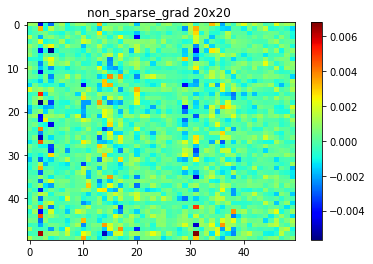

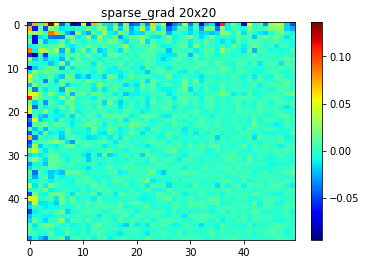

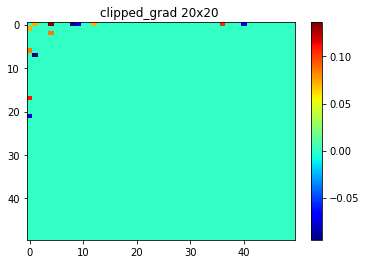

we get trashhold int tensor(0.2688, device='cuda:0')


we get trashhold out tensor(0.1796, device='cuda:0')




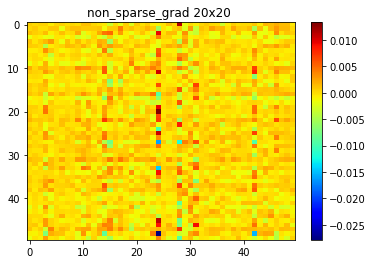

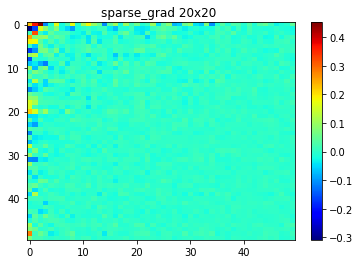

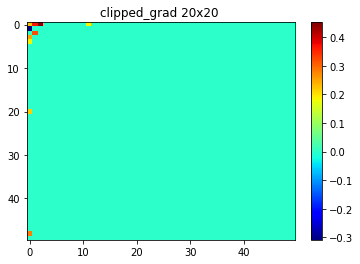

we get trashhold int tensor(0.4198, device='cuda:0')


we get trashhold out tensor(0.0641, device='cuda:0')


we get trashhold int tensor(0.2054, device='cuda:0')


we get trashhold out tensor(0.0650, device='cuda:0')


we get trashhold int tensor(0.2090, device='cuda:0')


we get trashhold out tensor(0.0611, device='cuda:0')


we get trashhold int tensor(0.2255, device='cuda:0')


we get trashhold out tensor(0.0560, device='cuda:0')


we get trashhold int tensor(0.2893, device='cuda:0')


we get trashhold out tensor(0.0687, device='cuda:0')


we get trashhold int tensor(0.1956, device='cuda:0')


we get trashhold out tensor(0.0764, device='cuda:0')


we get trashhold int tensor(0.3166, device='cuda:0')


we get trashhold out tensor(0.0780, device='cuda:0')


we get trashhold int tensor(0.3020, device='cuda:0')


we get trashhold out tensor(0.0507, device='cuda:0')


we get trashhold int tensor(0.1917, device='cuda:0')


we get trashhold out tensor(0.0896, device='cuda:0')


we get tra

KeyboardInterrupt: 

In [33]:
trainer.train()

In [36]:
trainer.U_out[3][0].dtype

torch.float32

In [ ]:
import matplotlib.pyplot as plt

plt.plot(trainer.losses, label='unfreeze dense layers freeze rest')
plt.plot(freeze, label='freeze dense layers freeze rest')
#plt.plot(freeze, label='freeze dense layers')
plt.title("Loss curves")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend()
plt.savefig("freeze0.png")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(trainer.losses, label='unfreeze dense layers freeze rest')
plt.plot(freeze, label='freeze dense layers freeze rest')
#plt.plot(freeze, label='freeze dense layers')
plt.title("Loss curves")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend()
plt.savefig("freeze0.png")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(trainer.losses, label='sparse dense layers')
plt.plot(full, label='unfreeze dense layers')
plt.plot(freeze, label='freeze dense layers')
plt.title("Loss curves")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend()
plt.savefig("freeze0.png")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(trainer.losses, label='all zeros')
plt.plot(full, label='full grads')
plt.title("Loss curves")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
a = np.stack(trainer.grad_bank_out[4][:28], axis = 0)
print (a.shape)
a = np.moveaxis(a, 0, 2)
print (a.shape)

In [ ]:
len(dict_int[0][4])

In [ ]:
import torch
dict_int = get_tucker_tensors(trainer.grad_bank_int)
dict_out = get_tucker_tensors(trainer.grad_bank_out)
print (dict_int[0].shape)
print (dict_int[1].shape)
for i in range(1):
    u1_int, u2_int = Tucker_Decomposition(dict_int[i])
    u1_out, u2_out = Tucker_Decomposition(dict_out[i])

In [ ]:
for i in range(1):
    print(i)

In [ ]:
print (u1_int.shape, u2_int.shape)

In [ ]:
def func_collecting_tensors(step, tensor1, tensor2=None):
    if step == 0:
        return tensor1.unsqueeze(0)
    else:
        return torch.concatenate((tensor1, tensor2),0)
    
def Tucker_Decomposition(tensor):
    n1, n2, n3 = tensor.shape
    u1, s1, v1 = np.linalg.svd(np.reshape(tensor, (n1, -1)), full_matrices=False)
    u2, s1, v1 = np.linalg.svd(np.reshape(np.transpose(tensor,[1,2,0]), (n2, -1)), full_matrices=False)
    u3, s1, v1 = np.linalg.svd(np.reshape(np.transpose(tensor,[2,0,1]), (n3, -1)), full_matrices=False)
    return u1, u2

def get_tucker_tensors(dict_layers):
    '''
    делает словарь где ключом будет слой, а значением будет тензор
    '''
    dict_tensor = dict(zip(range(12), [None]*12))
    for key in dict_layers.keys():
        dict_tensor[key] = np.moveaxis(np.stack(dict_layers[key][:28], axis = 0), 0, 2)
    return dict_tensor
    

In [ ]:
u1_int.T.shape

In [ ]:
matrix.shape

In [ ]:
for ind, matrix in enumerate(trainer.grad_bank_int[0][26:]):
    print ("layer", 0, "batch", ind+26)
    matrix_in_basis = u1_int.T @ matrix @ u2_int
    im= plt.imshow(matrix_in_basis, cmap='jet', aspect='auto')#not in spy
    plt.title('GRAD WEIGHTS ') 
    plt.colorbar(im) #not in spy
    plt.show()

    im= plt.imshow(matrix_in_basis[:50, :50], cmap='jet', aspect='auto')#not in spy
    plt.title('GRAD WEIGHTS '+'20x20 ') 
    plt.colorbar(im) #not in spy
    plt.show()
    print('\n\n\n\n')

In [ ]:
for ind, matrix in enumerate(trainer.grad_bank_out[0][26:]):
    print ("layer", 0, "batch", ind+26)
    matrix_in_basis = u1_out.T @ matrix @ u2_out
    im= plt.imshow(matrix_in_basis, cmap='jet', aspect='auto')#not in spy
    plt.title('GRAD WEIGHTS ') 
    plt.colorbar(im) #not in spy
    plt.show()

    im= plt.imshow(matrix_in_basis[:50, :50], cmap='jet', aspect='auto')#not in spy
    plt.title('GRAD WEIGHTS '+'20x20 ') 
    plt.colorbar(im) #not in spy
    plt.show()
    print('\n\n\n\n')

In [ ]:
import pickle

with open('regular_grad_int.pcl', 'wb') as fp:
    pickle.dump(trainer.grad_bank_int, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('regular_grad_out.pcl', 'wb') as fp:
    pickle.dump(trainer.grad_bank_out, fp, protocol=pickle.HIGHEST_PROTOCOL)



In [ ]:
import pickle

with open('sparse_s.pcl', 'wb') as fp:
    pickle.dump(trainer.sparse_grad_bank_int, fp, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
with open('regular_grad_int.pcl', 'rb') as fp:
    data = pickle.load(fp)

In [28]:
len(data[2])

NameError: name 'data' is not defined

In [29]:
for layer in range(len(trainer.sparse_grad_bank_int)):
  for batch in range(len(trainer.sparse_grad_bank_int[layer])):
      S_hat_zero= trainer.sparse_grad_bank_int[layer][batch]
      print ("layer", layer, "batch", batch)
      im= plt.imshow(S_hat_zero, cmap='jet', aspect='auto')#not in spy
      plt.title('GRAD WEIGHTS ') 
      plt.colorbar(im) #not in spy
      plt.show()

      im= plt.imshow(S_hat_zero[:20, :20], cmap='jet', aspect='auto')#not in spy
      plt.title('GRAD WEIGHTS '+'20x20 ') 
      plt.colorbar(im) #not in spy
      plt.show()
      print('\n\n\n\n')

NameError: name 'trainer' is not defined

get proper gradients (3rd output 3 layer)

In [ ]:
trainer.grad_bank_out[3]

tensor([[ 0.0087,  0.0019,  0.0022,  ..., -0.0060, -0.0029, -0.0028],
        [-0.0242, -0.0136,  0.0077,  ...,  0.0116, -0.0138, -0.0200],
        [ 0.0011, -0.0008, -0.0025,  ...,  0.0030,  0.0122,  0.0007],
        ...,
        [ 0.0208,  0.0178,  0.0109,  ...,  0.0239, -0.0072,  0.0082],
        [ 0.0068,  0.0190,  0.0222,  ...,  0.0137,  0.0079,  0.0078],
        [ 0.0094,  0.0085,  0.0064,  ...,  0.0164, -0.0020,  0.0097]])

In [ ]:
trainer.evaluate()

{'eval_loss': 0.46737247705459595,
 'eval_pearson': 0.8913607659252257,
 'eval_spearmanr': 0.8872514922959747,
 'eval_combined_score': 0.8893061291106001,
 'eval_runtime': 10.7561,
 'eval_samples_per_second': 139.456,
 'eval_steps_per_second': 1.116,
 'epoch': 1.0}

In [ ]:
trainer.save_model()  # Saves the tokenizer too for easy upload
#trainer.log_metrics("train", metrics)
metrics = trainer.evaluate()
trainer.save_metrics("eval", metrics)
trainer.save_state()
sst_new_path = r"./bert_stsb_128"

In [ ]:
#our model's params
orig_param = trainer.model.num_parameters() / 1000 / 1000
orig_param

109.48300900000001

In [ ]:
device='cuda'
def svd_compress_bert_ffn(model_to, svd_rank = 51):
    for i in range(model_to.config.num_hidden_layers):
        # fc part
        fc_w = model_to.bert.encoder.layer[i].intermediate.dense.weight.data.cpu().data.numpy()
        fc_b = model_to.bert.encoder.layer[i].intermediate.dense.bias.data.cpu().data.numpy()
        factorized_layer = factorize_to_svd(fc_w, fc_b, rank = svd_rank)
        model_to.bert.encoder.layer[i].intermediate.dense = factorized_layer
        
        fc_w = model_to.bert.encoder.layer[i].output.dense.weight.data.cpu().data.numpy()
        fc_b = model_to.bert.encoder.layer[i].output.dense.bias.data.cpu().data.numpy()
        factorized_layer = factorize_to_svd(fc_w, fc_b, rank = svd_rank)
        model_to.bert.encoder.layer[i].output.dense = factorized_layer

In [ ]:
from typing import List, Callable
import torch
import torch.nn as nn
import tntorch as tn
from math import sqrt

from ttm_opt import einsum_forward

class TTLinearOpt(nn.Module):
    def __init__(self, in_features: int, out_features: int, ranks: List[int], input_dims: List[int],
                 output_dims: List[int], bias: bool = True, device=None, dtype=None,
                 forward_fn: Callable = einsum_forward):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.ranks = list(ranks)
        self.input_dims = input_dims
        self.output_dims = output_dims
        self.forward_fn = forward_fn

        # Initialize weights from uniform[-1 / sqrt(in_features), 1 / sqrt(in_features)]
        factory_kwargs = {"device": device, "dtype": dtype}
        init = torch.rand(in_features, out_features, **factory_kwargs)
        init = (2 * init - 1) / sqrt(in_features)
        
        self.weight = tn.TTMatrix(init, list(ranks), input_dims, output_dims)

        # torch doesn't recognize attributes of self.weight as parameters,
        # so we have to use ParameterList
        self.cores = nn.ParameterList([nn.Parameter(core) for core in self.weight.cores])
        self.weight.cores = self.cores

        if bias:
            init = torch.rand(out_features, **factory_kwargs)
            init = (2 * init - 1) / sqrt(out_features)
            self.bias = nn.Parameter(init)
        else:
            self.register_parameter('bias', None)


    def forward(self, x: torch.Tensor):
        res = self.forward_fn(self.cores, x)

        new_shape = x.shape[:-1] + (self.out_features,)
        res = res.reshape(*new_shape)

        if self.bias is not None:
            res += self.bias

        return res

    def set_weight(self, new_weights: torch.Tensor):
        # in regular linear layer weights are transposed, so we transpose back
        new_weights = new_weights.clone().detach().T

        shape = torch.Size((self.in_features, self.out_features))
        assert new_weights.shape == shape, f"Expected shape {shape}, got {new_weights.shape}"

        self.weight = tn.TTMatrix(new_weights, self.ranks, self.input_dims, self.output_dims)
        self.cores = nn.ParameterList([nn.Parameter(core) for core in self.weight.cores])
        self.weight.cores = self.cores

    def set_from_linear(self, linear: nn.Linear):
        self.set_weight(linear.weight.data)
        self.bias = nn.Parameter(linear.bias.data.clone()) if linear.bias is not None else None

In [ ]:
def ttm_compress_bert_ffn(model, rank):
    if hasattr(model, "bert") and hasattr(model.bert, "encoder"):
        encoder = model.bert.encoder
    elif hasattr(model, "encoder"):
        encoder = model.encoder
    else:
        raise ValueError("Expected model to have attribute 'encoder' or 'bert.encoder'.")

    for i, layer in enumerate(encoder.layer):
        token_dim, hidden_dim = layer.intermediate.dense.weight.T.shape

        tt_weight = TTLinearOpt(768, 3072, [rank]*2,  [8,12,8], [12,16,16], bias=True)
        tt_weight.set_from_linear(layer.intermediate.dense)

        layer.intermediate.dense = tt_weight

        # second linear layerhas reversed dimensions,
        # so we swap input_dims and output_dims
        tt_weight = TTLinearOpt(3072, 768, [rank]*2, [12,16,16], [8,12,8], bias=True)
        tt_weight.set_from_linear(layer.output.dense)

        layer.output.dense = tt_weight

    return model

In [ ]:
from tqdm import tqdm

In [ ]:
dd = []
device='cuda'
for ii in tqdm([6,10,20]):
    trainer.model = AutoModelForSequenceClassification.from_pretrained(
                                                    sst_new_path,
                                                    config=config,
                                                    )
    svd_compress_bert_ffn(trainer.model, ii)
    trainer.model.to('cuda')
    new_param = trainer.model.num_parameters() / 1000 / 1000
    new_param /= orig_param
    ar = trainer.evaluate(tokenized_dataset["validation"])
    dd.append([new_param, ar['eval_pearson']])

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [01:35<00:00, 31.80s/it]


In [ ]:
dd_ttm = []
for ii in tqdm([6,10,20]): #,42,48,54,60,66,72,78,84]):
    trainer.model = AutoModelForSequenceClassification.from_pretrained(
                                                    sst_new_path,
                                                    config=config,
                                                    )
    ttm_compress_bert_ffn(trainer.model,ii)
    trainer.model.to('cuda')
    new_param = trainer.model.num_parameters() / 1000 / 1000
    new_param /= orig_param
    ar = trainer.evaluate(tokenized_dataset["validation"])
    dd_ttm.append([new_param, ar['eval_pearson']])

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [01:40<00:00, 33.54s/it]


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: xlabel='% of original params', ylabel='1'>

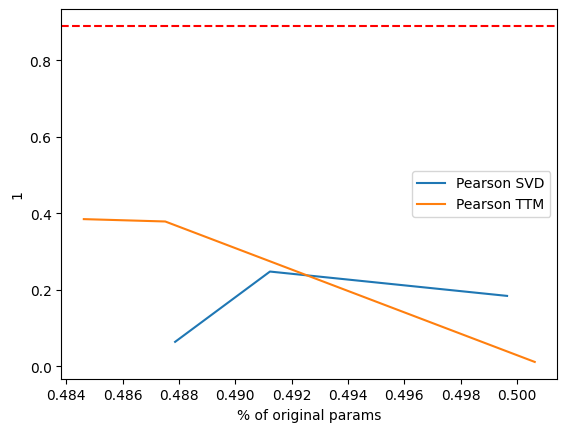

In [ ]:
ax = sns.lineplot(x=0, y=1, data = pd.DataFrame(dd), label='Pearson SVD')
plt.axhline(y=0.89, ls='--', c='red') #non-compressed accuracy
ax.set(xlabel ='% of original params')
sns.lineplot(x=0, y=1, data = pd.DataFrame(dd_ttm), label='Pearson TTM')